In [1]:
import numpy as np
import scipy as scp
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%load_ext line_profiler
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %install_default_config  %install_ext  %install_profiles  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %lprun  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%latex  %

In [3]:
train_mat = scipy.io.loadmat('mnist_train.mat')
train_data = train_mat['images'].T
train_labels = train_mat['labels']

test_mat = scipy.io.loadmat('mnist_test.mat')
test_data = test_mat['t10k_images']
test_labels = test_mat['t10k_labels']

In [14]:


test_kag = pd.read_csv('KaggleData/test.csv')


In [15]:
test_kag.iloc[:1,:]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_kag.shape

(28000, 784)

In [6]:
'''Simply calculates the means of the given test data for each class, then calculates the guassian probability of each
passed test example against each possible class (0-10) in order to classify the one with the highest probability'''
class simple_classifier():
    def __init__(self, train_data, train_labels, test_data, test_labels, test_kaggle):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_kaggle = test_kaggle
        self.means = list()
        
           
    def get_test_data(self):
        return self.test_data
    
    def get_test_labels(self):
        return self.test_labels
        
              
    
        
    def train(self):
        #  goes through every possible class
        for i in range(10):
            #  finds the list of label indexes in the training data which match the class of the interation
            number_i_indexes = np.where(train_labels == i)[0]
            #  then finds all correponding training data for the class, calculates the means of each pixel, the appends
            #  this mean image to the list of mean imgages for each class
            self.means.append(train_data[number_i_indexes].mean(axis=0))
            
            
    def classify(self, test_instance):
        highest_prob = float('-inf')
        highest_prob_index = -1
        
        for i, mean in enumerate(self.means):   
#             print("test_instance: ", test_instance)
#             print("mean: ", mean)
            prob = self.guassianProbability(test_instance,mean)
#             print("prob", prob)
            if prob > highest_prob:
                highest_prob = prob
                highest_prob_index = i
        
        return highest_prob_index
    
    
    
    def evaluate_model(self, num_of_instances_to_test):
        confusion_matrix = pd.DataFrame(np.zeros((10,10)))
        
        i = 0
        last_time = 0
        this_time = 0
        for test_instance, target_label in zip(test_data.T, test_labels):
            predicted_label = self.classify(test_instance)
    
#             print("predicted", predicted_label)
#             print("target", target_label)
#             print("highest prob: ", highest_prob)
            
            confusion_matrix.at[int(predicted_label),int(target_label)] += 1
            i += 1
            this_time = time.clo
            print("%d / %d  Time Remaining: " % (i, num_of_instances_to_test, ), end="\r")
            if i > num_of_instances_to_test:
                break
        
        total_incorrect = 0
        for i in range(len(confusion_matrix)):
            for j in range(len(confusion_matrix)):
                if i == j:
                    continue
                else:
                    total_incorrect += confusion_matrix.at[i,j]
                    
        print("Error Rate: ", (total_incorrect / len(test_labels)) * 100.0, "%")
        sns.heatmap(confusion_matrix)
        
        
        
        
    def output_kaggle_results(self):
        confusion_matrix = pd.DataFrame(np.zeros((10,10)))
        
        num_of_instances_to_test = len(self.test_kaggle)
        
        results = []
        
        i = 0
        last_time = 0
        this_time = 0
        for test_instance in self.test_kaggle.T:
            predicted_label = self.classify(test_instance)
    
#             print("predicted", predicted_label)
#             print("target", target_label)
#             print("highest prob: ", highest_prob)
            
            results.append(predicted_label)

            i += 1
#             this_time = time.clo
            print("%d / %d  Time Remaining: " % (i, num_of_instances_to_test, ), end="\r")
            if i > num_of_instances_to_test:
                break
                
        return results
        

    
    """This calculates the guassian prob for a value as compared to it's mean. It's follows the equation
    p(x|D)=e^(-0.5 * (x-xi) * (x-xi).T)
    This happens in log space"""
    def guassianProbability(self, x, xi):
#         print(shape(x))
#         print("x: ", x)
#         print(shape(xi))
#         print("xi: ", xi)
        x_diff = x - xi
#         print('x_diff: ', x_diff)
#         print('dot product', dot_product)
        return -0.5 * np.dot(x_diff, x_diff.T)
#         return (-0.5) * x_diff * x_diff.T * math.log(math.e)
    
    
    def printImageForEveryClass(self):
        fig, axes = plt.subplots(1,10)       
        for i,img in enumerate(self.means):
            axes[i].imshow(img.reshape(28,28).T, interpolation='nearest', cmap=matplotlib.cm.gray)

    


# #1 Visualize Expected

Wall time: 545 ms


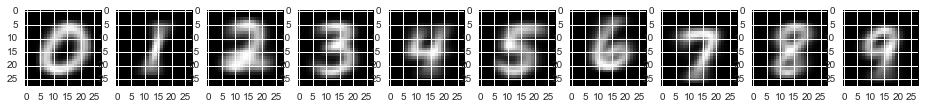

In [11]:
%%time 
simple = simple_classifier(train_data, train_labels, test_data, test_labels)
simple.train()
simple.printImageForEveryClass()

# #2 Simple Classifier


Error Rate:  2.11 %
Wall time: 256 ms


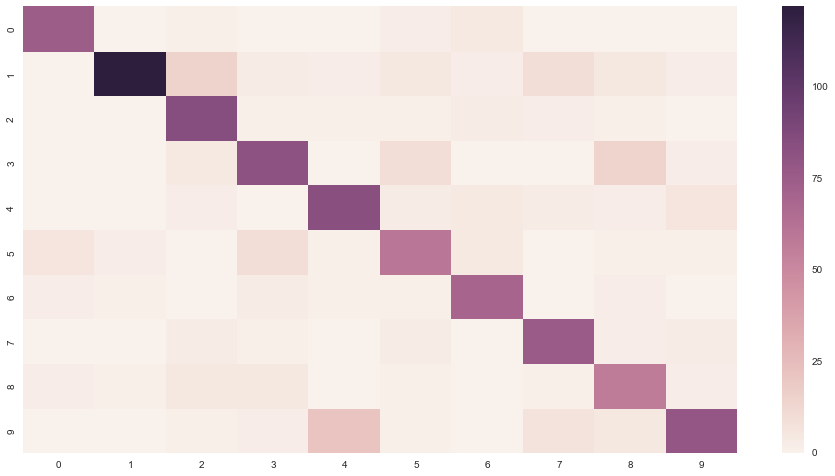

In [12]:
# %lprun -f simple.evaluate_model -f simple.classify -f simple.guassianProbability simple.evaluate_model(1000)
%time simple.evaluate_model(1000)


In [7]:
%lprun?

# #3 Full KDE

In [7]:
class full_kde_classifier(simple_classifier):
    """Finds the gaussian probability the test instance is related to each individual training instance, then adds the corresponding
    probability to the training instance's class' total probability count. Whichever class has the highest probability sum
    after all training instances are compared to the test instance is chosen as the classification"""   
    def classify(self, test_instance):
        total_class_probabilities =  [0] * 10
        for train_instance, instance_label in zip(self.train_data, self.train_labels):
            prob = self.guassianProbability(test_instance, train_instance)
            total_class_probabilities[instance_label] += prob
            
        return np.argmax(total_class_probabilities)  #  this returns the index of the highest value, which is also the class

#     def classify(self, test_instance):
#         total_class_probabilities = [0] * 10
#         for i, train_instance, train_instance_label in zip(train_data, train_labels):
#             prob = self.guassianProbability(test_instance, train_instance)
#             total_class_probabilities[train_labels[i]] += prob
            
#         return np.argmax(total_class_probabilities)  #  this returns the index of the highest value, which is also the class

 

In [17]:
%time %lprun -f full_kde_classifier.__init__  full_kde = full_kde_classifier(train_data, train_labels, test_data, test_labels, test_kag)


Wall time: 2 ms


In [ ]:
%time %prun full_kde.evaluate_model(1000)

Error Rate:  3.27 %


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


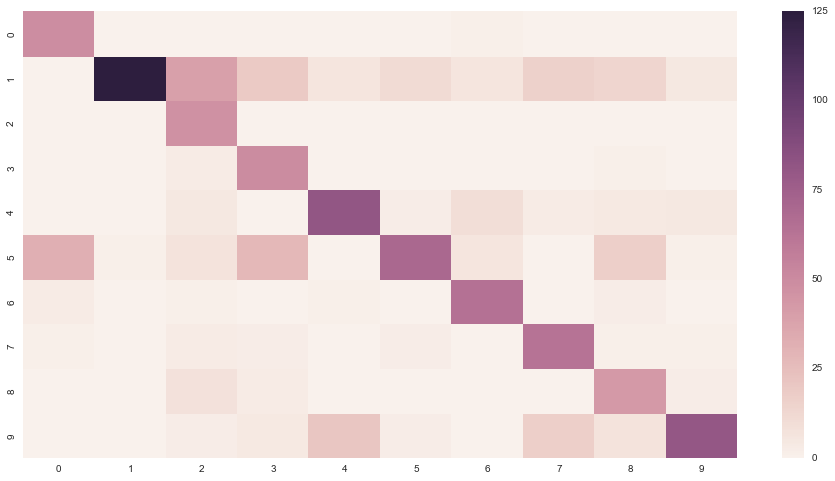

In [15]:
%lprun -f full_kde.evaluate_model -f full_kde.classify -f full_kde.guassianProbability full_kde.evaluate_model(1000)


In [18]:
results = full_kde.output_kaggle_results()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [19]:
sfile = open( 'results_3.csv', 'w' )
sfile.write( '"ImageId","Label"\n' )
for i, classification in enumerate(results):
    sfile.write( '%d,%d\n' % ( i,classification) )  # add one for one-based indexing
sfile.close()

In [ ]:
%time full_kde = full_kde_classifier(train_data, train_labels, test_data, test_labels)

full_kde.find_outlier()